# Proyecto de limpieza de datos
Autor: Iñaki Sebastián Orozco García    

Fecha: 24/11/2024

Para este proyecto usaré un dataset de BackBlaze una empresa de servidores que lleva años recabando la información S.M.A.R.T (Métricas estandarizadas de evaluación) de los discos duros de sus equipos con el atributo agregado Failure que indica si ese disco falló al día siguiente, este dataset es en el que he estado trabajando en mi proyecto de tesis para hacer predicciones de fallas con un árbol de decisión y una LSTM. 

Los 3 puntos en los que trabajaré en este proyecto giran en torno a un buen desempeño usando este set de datos en esos dos algoritmos (DT, LSTM) donde ya hay un trabajo previo en donde se buscó un set de datos que tuviera buen desempeño y se encontró que los mejores atributos son los presentes en varios documentos del estado del arte, son los siguientes:
[SMART Attribute list](https://en.wikipedia.org/wiki/Self-Monitoring,_Analysis_and_Reporting_Technology)
| ID # | Attribute Name                     | Column Index | Column Name                |
|------|------------------------------------|--------------|----------------------------|
| 1    | Raw Read Error Rate                | 11           | smart_1_normalized         |
| 3    | Spin Up Time                       | 13           | smart_3_normalized         |
| 5    | Reallocated Sectors Count          | 17           | smart_5_normalized         |
| 7    | Seek Error Rate                    | 21           | smart_7_normalized         |
| 9    | Power On Hours                     | 25           | smart_9_normalized         |
| 187  | Reported Uncorrectable Errors      | 187          | smart_187_normalized       |
| 189  | High Fly Writes                    | 191          | smart_189_normalized       |
| 194  | Temperature Celsius                | 195          | smart_194_normalized       |
| 195  | Hardware ECC Recovered             | 197          | smart_195_normalized       |
| 197  | Current Pending Sector Count       | 199          | smart_197_normalized       |
| 5    | Reallocated Sectors Count (raw value) | 18        | smart_5_raw                |
| 197  | Current Pending Sector Count (raw value) | 200    | smart_197_raw              |


In [228]:
S_O_T_A_features = [f"smart_{i}_normalized" for i in [1, 3, 5, 7, 9, 187, 189, 194, 195, 197]]
S_O_T_A_features += ["smart_5_raw", "smart_197_raw"]

- Imputación de datos faltantes             <- Elegida 
- Codificación de variables categóricas     <- Elegida
- Transformación de potencia
- Escalamiento                              <- Elegida
- Discretización

Esto es lo que se hará con las columnas del dataframe:

- date: Nada, nos sirve para la LSTM.
- serial_number: Variable categórica.
- model: Variable categórica, se va a dividir dos variables: Empresa y modelo.
- capacity_bytes: Variable categórica.
- failure: Nada.
---------
- datacenter: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- cluster_id: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- vault_id: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- pod_id: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- pod_slot_num: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
- is_legacy_format: Eliminarla, no es reelevante para nosotros le sirve a la empresa que comparte el set de datos.
--------

y también los smart que son de dos tipos:
- smart_normalized: PENDIENTE
- smart_raw: PENDIENTE

# Procesamiento inicial 

### Importar el set de datos en un dataframe de pandas

In [229]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from feature_engine.imputation import RandomSampleImputer

Como nuestro dataset tiene muchos datos, definiré unas funciones para procesar los datos en chunks eliminando las columnas que no nos interesan sin cargarlas al df.

In [273]:
def process_chunks(file_path):
    chunksize = 10 ** 6
    dtype_dict = {'date': 'str', 'serial_number': 'str', 'model': 'str', 'capacity_bytes': 'object', 'failure': 'bool', 'datacenter': 'str', 'cluster_id': 'int8', 'vault_id': 'int16', 'pod_id': 'int16', 'pod_slot_num': 'float32', 'is_legacy_format': 'bool', 'smart_1_normalized': 'float64', 'smart_1_raw': 'float64', 'smart_2_normalized': 'float64', 'smart_2_raw': 'float64', 'smart_3_normalized': 'float64', 'smart_3_raw': 'float64', 'smart_4_normalized': 'float64', 'smart_4_raw': 'float64', 'smart_5_normalized': 'float64', 'smart_5_raw': 'float64', 'smart_7_normalized': 'float64', 'smart_7_raw': 'float64', 'smart_8_normalized': 'float64', 'smart_8_raw': 'float64', 'smart_9_normalized': 'float64', 'smart_9_raw': 'float64', 'smart_10_normalized': 'float64', 'smart_10_raw': 'float64', 'smart_11_normalized': 'float64', 'smart_11_raw': 'float64', 'smart_12_normalized': 'float64', 'smart_12_raw': 'float64', 'smart_13_normalized': 'float64', 'smart_13_raw': 'float64', 'smart_15_normalized': 'float64', 'smart_15_raw': 'float64', 'smart_16_normalized': 'float64', 'smart_16_raw': 'float64', 'smart_17_normalized': 'float64', 'smart_17_raw': 'float64', 'smart_18_normalized': 'float64', 'smart_18_raw': 'float64', 'smart_22_normalized': 'float64', 'smart_22_raw': 'float64', 'smart_23_normalized': 'float64', 'smart_23_raw': 'float64', 'smart_24_normalized': 'float64', 'smart_24_raw': 'float64', 'smart_27_normalized': 'float64', 'smart_27_raw': 'float64', 'smart_71_normalized': 'float64', 'smart_71_raw': 'float64', 'smart_82_normalized': 'float64', 'smart_82_raw': 'float64', 'smart_90_normalized': 'float64', 'smart_90_raw': 'float64', 'smart_160_normalized': 'float64', 'smart_160_raw': 'float64', 'smart_161_normalized': 'float64', 'smart_161_raw': 'float64', 'smart_163_normalized': 'float64', 'smart_163_raw': 'float64', 'smart_164_normalized': 'float64', 'smart_164_raw': 'float64', 'smart_165_normalized': 'float64', 'smart_165_raw': 'float64', 'smart_166_normalized': 'float64', 'smart_166_raw': 'float64', 'smart_167_normalized': 'float64', 'smart_167_raw': 'float64', 'smart_168_normalized': 'float64', 'smart_168_raw': 'float64', 'smart_169_normalized': 'float64', 'smart_169_raw': 'float64', 'smart_170_normalized': 'float64', 'smart_170_raw': 'float64', 'smart_171_normalized': 'float64', 'smart_171_raw': 'float64', 'smart_172_normalized': 'float64', 'smart_172_raw': 'float64', 'smart_173_normalized': 'float64', 'smart_173_raw': 'float64', 'smart_174_normalized': 'float64', 'smart_174_raw': 'float64', 'smart_175_normalized': 'float64', 'smart_175_raw': 'float64', 'smart_176_normalized': 'float64', 'smart_176_raw': 'float64', 'smart_177_normalized': 'float64', 'smart_177_raw': 'float64', 'smart_178_normalized': 'float64', 'smart_178_raw': 'float64', 'smart_179_normalized': 'float64', 'smart_179_raw': 'float64', 'smart_180_normalized': 'float64', 'smart_180_raw': 'float64', 'smart_181_normalized': 'float64', 'smart_181_raw': 'float64', 'smart_182_normalized': 'float64', 'smart_182_raw': 'float64', 'smart_183_normalized': 'float64', 'smart_183_raw': 'float64', 'smart_184_normalized': 'float64', 'smart_184_raw': 'float64', 'smart_187_normalized': 'float64', 'smart_187_raw': 'float64', 'smart_188_normalized': 'float64', 'smart_188_raw': 'float64', 'smart_189_normalized': 'float64', 'smart_189_raw': 'float64', 'smart_190_normalized': 'float64', 'smart_190_raw': 'float64', 'smart_191_normalized': 'float64', 'smart_191_raw': 'float64', 'smart_192_normalized': 'float64', 'smart_192_raw': 'float64', 'smart_193_normalized': 'float64', 'smart_193_raw': 'float64', 'smart_194_normalized': 'float64', 'smart_194_raw': 'float64', 'smart_195_normalized': 'float64', 'smart_195_raw': 'float64', 'smart_196_normalized': 'float64', 'smart_196_raw': 'float64', 'smart_197_normalized': 'float64', 'smart_197_raw': 'float64', 'smart_198_normalized': 'float64', 'smart_198_raw': 'float64', 'smart_199_normalized': 'float64', 'smart_199_raw': 'float64', 'smart_200_normalized': 'float64', 'smart_200_raw': 'float64', 'smart_201_normalized': 'float64', 'smart_201_raw': 'float64', 'smart_202_normalized': 'float64', 'smart_202_raw': 'float64', 'smart_206_normalized': 'float64', 'smart_206_raw': 'float64', 'smart_210_normalized': 'float64', 'smart_210_raw': 'float64', 'smart_218_normalized': 'float64', 'smart_218_raw': 'float64', 'smart_220_normalized': 'float64', 'smart_220_raw': 'float64', 'smart_222_normalized': 'float64', 'smart_222_raw': 'float64', 'smart_223_normalized': 'float64', 'smart_223_raw': 'float64', 'smart_224_normalized': 'float64', 'smart_224_raw': 'float64', 'smart_225_normalized': 'float64', 'smart_225_raw': 'float64', 'smart_226_normalized': 'float64', 'smart_226_raw': 'float64', 'smart_230_normalized': 'float64', 'smart_230_raw': 'float64', 'smart_231_normalized': 'float64', 'smart_231_raw': 'float64', 'smart_232_normalized': 'float64', 'smart_232_raw': 'float64', 'smart_233_normalized': 'float64', 'smart_233_raw': 'float64', 'smart_234_normalized': 'float64', 'smart_234_raw': 'float64', 'smart_235_normalized': 'float64', 'smart_235_raw': 'float64', 'smart_240_normalized': 'float64', 'smart_240_raw': 'float64', 'smart_241_normalized': 'float64', 'smart_241_raw': 'float64', 'smart_242_normalized': 'float64', 'smart_242_raw': 'float64', 'smart_244_normalized': 'float64', 'smart_244_raw': 'float64', 'smart_245_normalized': 'float64', 'smart_245_raw': 'float64', 'smart_246_normalized': 'float64', 'smart_246_raw': 'float64', 'smart_247_normalized': 'float64', 'smart_247_raw': 'float64', 'smart_248_normalized': 'float64', 'smart_248_raw': 'float64', 'smart_250_normalized': 'float64', 'smart_250_raw': 'float64', 'smart_251_normalized': 'float64', 'smart_251_raw': 'float64', 'smart_252_normalized': 'float64', 'smart_252_raw': 'float64', 'smart_254_normalized': 'float64', 'smart_254_raw': 'float64', 'smart_255_normalized': 'float64', 'smart_255_raw': 'float64', 'capacity_gb': 'float64'}
    aggregated_result = pd.DataFrame() 

    for chunk in pd.read_csv(file_path, chunksize=chunksize, dtype=dtype_dict):
        chunk = delete_rows(chunk)
        aggregated_result = pd.concat([aggregated_result, chunk])

    return aggregated_result

def delete_rows(df):
    df.head()
    columns_to_delete = ['datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format']
    columns_to_delete += [col for col in df.columns if col.startswith('smart') and col not in S_O_T_A_features]
    df = df.drop(columns=columns_to_delete)
    return df


def getdata(folder_path, num_files):
    df = pd.DataFrame()
    for idx, file_name in enumerate(os.listdir(folder_path)):
        if num_files == -1:
            if file_name.endswith(".csv"):
                file_path = os.path.join(folder_path, file_name)
                temp_df = process_chunks(file_path)
                df = pd.concat([df, temp_df])
                print(file_path, ' done')
        elif num_files > 0:
            if num_files == idx-1:
                return df
            if file_name.endswith(".csv"):
                file_path = os.path.join(folder_path, file_name)
                temp_df = process_chunks(file_path)
                df = pd.concat([df, temp_df])
                print(file_path, ' done')
    print(df.columns)
    return df

Cargamos los datos en el df sin las columnas innecesarias

In [231]:
folder_path = '../data/external/data_Q3_2024/data_Q3_2024'

df = getdata(folder_path, 10)

../data/external/data_Q3_2024/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-02.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-03.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-04.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-05.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-06.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-07.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-08.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-09.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-10.csv  done


### Analizamos el dataframe 

Generamos un varias gráficas de mapas de calor para visualizar el df y los atributos nulos que tiene.

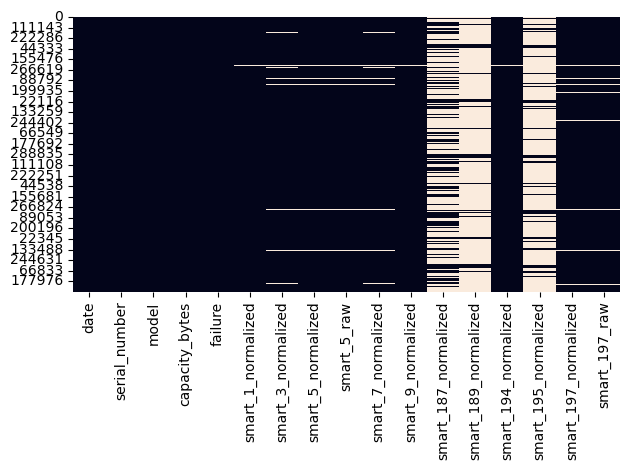

In [232]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.savefig(f'../reports/figures/heat_maps/heat_map_.png')
plt.close()

Podemos ver esas 3 variables que tienen muchos datos nulos, pero como ya vimos que nuestro modelo del arbol de decisión tiene buen desempeño incluso con tantos datos faltantes intentaremos trabajar con ellas

Ahora eliminaremos las columnas que solo tienen datos faltantes.

In [233]:
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only NaN values: {nan_columns}")

df = df.drop(columns=nan_columns)

Columns with only NaN values: []


Imprimimos las columnas y los elementos que más aparecen para hacernos una idea de que que haremos con los distintos datos.

In [234]:
for column in df.columns:
    print(f"Column: {column}")
    print(f"Top 3 most occurring elements: {df[column].value_counts().head(3).to_dict().keys()}")
    print(f"Number of NaN values: {df[column].isna().sum()}")
    print("\n")

Column: date
Top 3 most occurring elements: dict_keys(['2024-07-10', '2024-07-01', '2024-07-04'])
Number of NaN values: 0


Column: serial_number
Top 3 most occurring elements: dict_keys(['PL1331LAGXN3AH', '8160A0RSFVKG', '8160A0YNFVKG'])
Number of NaN values: 0


Column: model
Top 3 most occurring elements: dict_keys(['TOSHIBA MG08ACA16TA', 'TOSHIBA MG07ACA14TA', 'ST16000NM001G'])
Number of NaN values: 0


Column: capacity_bytes
Top 3 most occurring elements: dict_keys([16000900661248, 12000138625024, 14000519643136])
Number of NaN values: 0


Column: failure
Top 3 most occurring elements: dict_keys([False, True])
Number of NaN values: 0


Column: smart_1_normalized
Top 3 most occurring elements: dict_keys([100.0, 83.0, 82.0])
Number of NaN values: 7336


Column: smart_3_normalized
Top 3 most occurring elements: dict_keys([100.0, 84.0, 90.0])
Number of NaN values: 33734


Column: smart_5_normalized
Top 3 most occurring elements: dict_keys([100.0, 99.0, 252.0])
Number of NaN values: 23

Podemos ver que las columnas con variables categóricas no tienen variables faltantes, vamos a trabajar solo reemplazando datos faltantes con las variables numéricas que pertenecen a los atributos S.M.A.R.T, hay normalizadas y crudas.

In [235]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column: {column}, NaN values: {nan_count}")

Column: smart_1_normalized, NaN values: 7336
Column: smart_3_normalized, NaN values: 33734
Column: smart_5_normalized, NaN values: 23156
Column: smart_5_raw, NaN values: 23156
Column: smart_7_normalized, NaN values: 33734
Column: smart_9_normalized, NaN values: 4500
Column: smart_187_normalized, NaN values: 1806948
Column: smart_189_normalized, NaN values: 2621852
Column: smart_194_normalized, NaN values: 4500
Column: smart_195_normalized, NaN values: 2426672
Column: smart_197_normalized, NaN values: 86002
Column: smart_197_raw, NaN values: 86002


# Imputación de datos faltantes
----------
[Tratamiento de datos faltantes](D:/Downloads/Tratamiento_de_datos_faltantes_PDF.pdf)

La moda se usa para imputar predictores cualitativos (Variables categóricas) y el promedio o la mediana se usa para imputar predictores
cuantitativos (Variables numéricas).

### Variables categóricas

Variables categóricas con elementos NaN del dataset: ninguna

In [236]:
nan_counts = df.iloc[:, :5].isna().sum()
print(nan_counts)

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
dtype: int64


### Variables numéricas
Evaluamos la distribución:

En una distribución uniforme, el método a emplear debe ser la sustitución aleatoria; en cambio, si la distribución es semejante a la normal, es decir, simétrica y curtósis mayor a -1.0, si la variable muestra datos atípicos, se
aplica la sustitución por mediana, ya que esta medida de tendencia central no varía en la presencia de tales valores;
de lo contrario, se usa la sustitución por media aritmética

In [237]:
output_dir = '../reports/figures/histogramas/'
os.makedirs(output_dir, exist_ok=True)

# Crear histogramas para las columnas 6 en adelante
for column in df.columns[5:]:
    plt.figure(figsize=(10, 6))
    df[column].dropna().hist(bins=50)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.savefig(f'{output_dir}{column}_histograma.png')
    plt.close()

Sustitución aleatoria (Kurtosis menor a -1.0 y distribución uniforme)

Columnas con kurtosis menor a -1.0: ['smart_195_normalized']


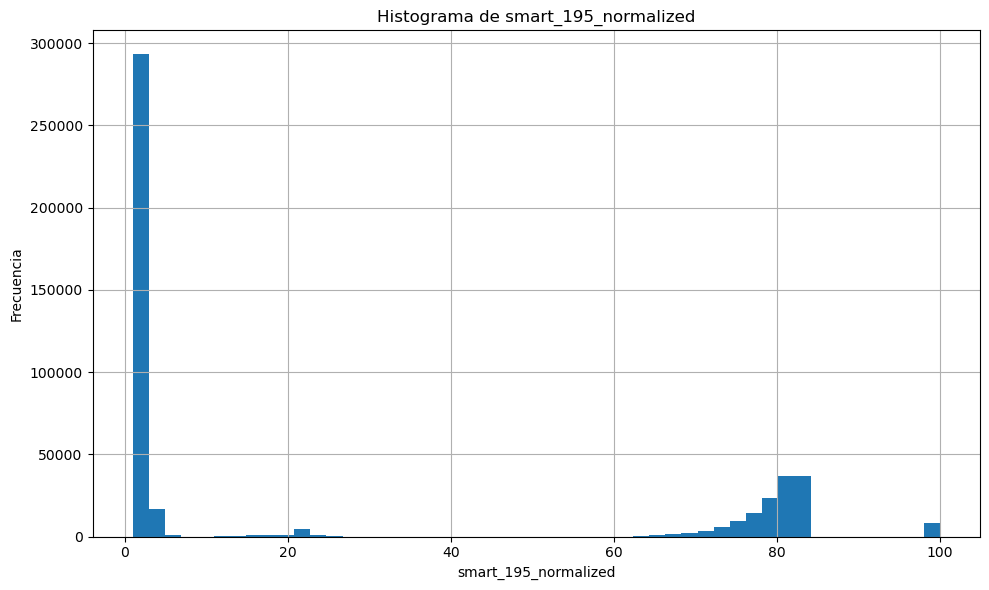

In [238]:
df_smart = df.iloc[:, 5:]
kurtosis_columns = [col for col in df_smart.columns if df_smart[col].kurtosis() < -1.0]
print(f"Columnas con kurtosis menor a -1.0: {kurtosis_columns}")
# Plot the column with kurtosis less than -1.0
for col in kurtosis_columns:
    plt.figure(figsize=(10, 6))
    df[col].dropna().hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.savefig(f'../reports/figures/histogramas/{col}_histograma.png')
    plt.tight_layout()
    plt.show()
    plt.close()


#### Analizamos en búsqueda de datos atípicos:

Con el IQR vemos que columnas tienen anomalías y las guardamos en un diccionario

In [239]:
# Calcular el rango intercuartílico (IQR) para las columnas 6 en adelante
iqr_values = {}
outliers_dict = {}
no_kurtosis_df = df.drop(columns=kurtosis_columns)
for column in no_kurtosis_df.columns[5:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = IQR
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {column}: {outliers.shape[0]}")
    if not outliers.empty:
        outliers_dict[column] = outliers

Outliers in column smart_1_normalized: 1364
Outliers in column smart_3_normalized: 185803
Outliers in column smart_5_normalized: 10299
Outliers in column smart_5_raw: 109682
Outliers in column smart_7_normalized: 17378
Outliers in column smart_9_normalized: 0
Outliers in column smart_187_normalized: 40631
Outliers in column smart_189_normalized: 10790
Outliers in column smart_194_normalized: 96346
Outliers in column smart_197_normalized: 3595
Outliers in column smart_197_raw: 37964


Creamos el diccionario para sustituir los valores nulos

In [240]:
valores = {}
for column in df.columns[5:]:
    if column not in kurtosis_columns:
        if column in outliers:
            valores[column] = df[column].median()
        else:
            valores[column] = df[column].mean()

print(valores)

{'smart_1_normalized': 100.0, 'smart_3_normalized': 97.0, 'smart_5_normalized': 100.0, 'smart_5_raw': 0.0, 'smart_7_normalized': 100.0, 'smart_9_normalized': 74.0, 'smart_187_normalized': 100.0, 'smart_189_normalized': 100.0, 'smart_194_normalized': 61.0, 'smart_197_normalized': 100.0, 'smart_197_raw': 0.0}


In [241]:
df=df.fillna(valores)
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 1


In [242]:

aleatorio=RandomSampleImputer()
for column in kurtosis_columns:
    df[column]=aleatorio.fit_transform(df[[column]])
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


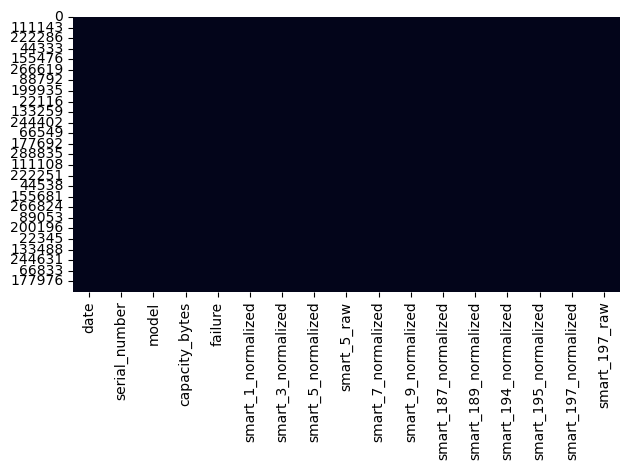

In [243]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.close()

# Codificación de variables categóricas
-------------
[Codificación de variables categóricas](D:/Downloads/codificacion_var_categoricas.pdf)

Variables que convertiremos a una variable categórica:
- model: Se va a dividir dos variables: Empresa y modelo.
- capacity_bytes: los separaremos en distintas categorías dependiendo de la cantidad de almacenamiento


https://colab.research.google.com/drive/14hSbGZjv6-tNR9ZeQQ3IWw27dUPFaIBY?usp=drive_open#scrollTo=HZGgKjgHr_ph

In [244]:
# Calcular la frecuencia de cada modelo
model_freq = df['model'].value_counts()

# Crear un diccionario para mapear cada modelo a su frecuencia
model_freq_dict = model_freq.to_dict()

# Crear una nueva columna categórica basada en la frecuencia de uso
df['model_freq'] = df['model'].map(model_freq_dict)

# Convertir la nueva columna a tipo categórico
df['model_freq'] = pd.cut(df['model_freq'], bins=[0, 10, 100, 1000, 10000, float('inf')],
                          labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(df[['model', 'model_freq']].head())

                  model model_freq
0  HGST HDS5C4040ALE630       Bajo
1  HGST HMS5C4040ALE640       Alto
2         ST500LM012 HN       Alto
3           ST4000DM000   Muy Alto
4           ST4000DM000   Muy Alto


In [245]:
import re

def extract_brand(model):
    match = re.match(r'^[A-Za-z]+', model)
    return match.group(0) if match else None

df['brand'] = df['model'].apply(extract_brand)
print(df['brand'].drop_duplicates())

0             HGST
2               ST
46         TOSHIBA
459        Seagate
509            WDC
873            WUH
980             WD
1102            CT
1468        Micron
2368       Hitachi
41825     DELLBOSS
150912     MTFDDAV
151848    SSDSCKKB
Name: brand, dtype: object


In [246]:
print(df.head())

         date   serial_number                 model  capacity_bytes  failure  \
0  2024-07-01  PL1331LAGXN3AH  HGST HDS5C4040ALE630   4000787030016    False   
1  2024-07-01  PL2331LAGSTSYJ  HGST HMS5C4040ALE640   4000787030016    False   
2  2024-07-01  S2ZYJ9FG405079         ST500LM012 HN    500107862016    False   
3  2024-07-01        Z3056CGY           ST4000DM000   4000787030016    False   
4  2024-07-01        Z305FT10           ST4000DM000   4000787030016    False   

   smart_1_normalized  smart_3_normalized  smart_5_normalized  smart_5_raw  \
0               100.0               130.0               100.0          0.0   
1               100.0               128.0               100.0          0.0   
2               100.0                94.0               252.0          0.0   
3               120.0                92.0               100.0          0.0   
4               114.0                91.0               100.0          0.0   

   smart_7_normalized  smart_9_normalized  smart_1

Convirtiendo a categórica ordinal capacity_bytes:

Aquí hay un problema grave y es que el df empieza a eliminar datos de la columna capacity_bytes y los reemplaza por un -1 a su antojo, he estado 2 horas intentando solucionarlo y no he podido, al parecer al cargar el 2 csv, muchos datos del 1 se reemplazan por -1 en vez de por su dato normal, si solo cargo 1 csv esto no se observa, además de esto parece que NINGUNO de los valores guardados en la columna de capacity_bytes corresponden a ningún valor existente de los .csv, yo al hacer la conversión a df los estoy casteando como int64 que debería tomar espacio suficiente para que se importen y parece que si solo creo el df a partir de 1 csv este error no se observa.

In [262]:
df = getdata(folder_path, 1)

../data/external/data_Q3_2024/data_Q3_2024\2024-07-01.csv  done


In [263]:
print(df['capacity_bytes'].unique())

['4000787030016' '500107862016' '16000900661248' '250059350016'
 '8001563222016' '480103981056' '2000398934016' '12000138625024'
 '10000831348736' '14000519643136' '480036847616' '1000204886016'
 '18000207937536' '240057409536' '22000969973760' '20000588955648']


In [264]:
# Filter the dataframe to get rows where capacity_bytes is -1
filtered_df = df[df['capacity_bytes'] == -1]

# Select the unique serial numbers
unique_serial_numbers = filtered_df['serial_number'].unique()

# Display the result
print("Capacity bytes that are -1 and their corresponding unique serial numbers:")
print(unique_serial_numbers)

Capacity bytes that are -1 and their corresponding unique serial numbers:
[]


Ahora el error:

In [265]:
df = getdata(folder_path, 2)

../data/external/data_Q3_2024/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-02.csv  done


In [267]:
# Filter the dataframe to get rows where capacity_bytes is -1
filtered_df = df[df['capacity_bytes'] == '-1']

# Select the unique serial numbers
unique_serial_numbers = filtered_df['serial_number'].unique()

# Display the result
print("Capacity bytes that are -1 and their corresponding unique serial numbers:")
print(unique_serial_numbers)

Capacity bytes that are -1 and their corresponding unique serial numbers:
['3050A03PF97G' '3050A03QF97G' '3050A04JF97G' '3060A003F97G'
 '3060A004F97G' '3060A00AF97G' '3060A00LF97G' '3060A00WF97G'
 '3060A01JF97G' '3060A01KF97G' '3060A025F97G' '3060A02AF97G'
 '3060A02DF97G' '3060A02EF97G' '3060A02SF97G' '3060A02TF97G'
 '3060A02UF97G' '3060A02XF97G' '3060A033F97G' '3060A037F97G'
 '3060A06PF97G' '3070A002F97G' '3070A02PF97G' '3070A02WF97G'
 '3070A05UF97G' '3070A09QF97G' '3070A0TNF97G']


Crece exponencialmente el reemplazo por -1

In [270]:
print(sorted(df['capacity_bytes'].unique()))
print(df[df['capacity_bytes'] == '-1'].shape[0])

['-1', '10000831348736', '1000204886016', '12000138625024', '14000519643136', '16000900661248', '18000207937536', '20000588955648', '2000398934016', '22000969973760', '240057409536', '250059350016', '4000787030016', '480036847616', '480103981056', '500107862016', '8001563222016']
27


In [ ]:
df = getdata(folder_path, 10)

../data/external/data_Q3_2024/data_Q3_2024\2024-07-01.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-02.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-03.csv  done
../data/external/data_Q3_2024/data_Q3_2024\2024-07-04.csv  done


In [275]:
print(sorted(df['capacity_bytes'].unique()))
print(df[df['capacity_bytes'] == '-1'].shape[0])

['-1', '10000831348736', '1000204886016', '12000138625024', '14000519643136', '16000900661248', '18000207937536', '20000588955648', '2000398934016', '22000969973760', '240057409536', '250059350016', '4000787030016', '480036847616', '480103981056', '500107862016', '8001563222016']
27


In [248]:
Var=df['capacity_bytes']                      # Variable categórica ordinal
n=Var.nunique()                     # Cardinalidad
lim_inf=(n-1)//2 if n%2!=0 else n-1 # Abs del límite inferior
step=1 if n%2!=0 else 2             # Intervalo
X=range(-lim_inf,lim_inf+1,step)
list(X)

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [249]:
print(Var.unique())

[ 4000787030016   500107862016 16000900661248   250059350016
  8001563222016   480103981056  2000398934016 12000138625024
 10000831348736 14000519643136   480036847616  1000204886016
 18000207937536   240057409536 22000969973760 20000588955648
             -1]


In [250]:
beta0=0
beta1=1 # beta1>0  ->  codificación creciente. beta1<0  ->  codificación decreciente
y=[beta0+beta1*x for x in X]
y

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [251]:
# Asociamos estos valores a las categorías ordenadas de 'Var'
# Var.unique()
Var_ord=np.concatenate([Var.unique()[1:],Var.unique()[:1]])
Var_ord

array([  500107862016, 16000900661248,   250059350016,  8001563222016,
         480103981056,  2000398934016, 12000138625024, 10000831348736,
       14000519643136,   480036847616,  1000204886016, 18000207937536,
         240057409536, 22000969973760, 20000588955648,             -1,
        4000787030016], dtype=int64)

# Escalamiento